# Brownian Motion and Applications

A Geometric Brownian motion is a continuous-time stochastic process. More rigorously, Geometric Brownian motion process is specified through an stochastic differential equation (SDE) of the form

***dSₜ = μSₜdt + σSₜdWₜ***

*   Sₜ = the stock price
*   dSₜ = the change in stock price
*   μ = the expected return
*   σ = the standard deviation of returns
*   Wₜ = the Wiener Process random variable where increments in t time have a normal distribution N that is centered at zero (i.e Wₜ -W₀~ N(0,t) )
*   dₜ = the elapsed time period​

Some key assumptions include that the random variable is normally distributed so in this case, we use the logarithmic change of the stock price which is assumed as such. Volatility / standard deviation is constant. Expected return is independent of current price / performance.

In [14]:
import numpy as np
import matplotlib.pyplot as plt

The above SDE has an analytic solution which is implemented below.

In [ ]:
def BrownianMotion(S, T, r, q, sigma, steps, N):
    """
    Inputs
    S:  Current stock Price
    K:  Strike Price
    T:  Time to maturity 1 year = 1, 1 months = 1/12
    r:  risk free interest rate
    q:  dividend yield
    sigma:  volatility 
    
    Output
    [steps,N]: Matrix of asset paths 
    """
    dt = T/steps
    #S_{T} = ln(S_{0})+\int_{0}^T(\mu-\frac{\sigma^2}{2})dt+\int_{0}^T \sigma dW(t)
    ST = np.log(S) +  np.cumsum(((r - q - sigma**2/2)*dt +\
                              sigma*np.sqrt(dt) * \
                              np.random.normal(size=(steps,N))),axis=0)
    
    return np.exp(ST)

Text(0.5, 1.0, 'Geometric Brownian Motion')

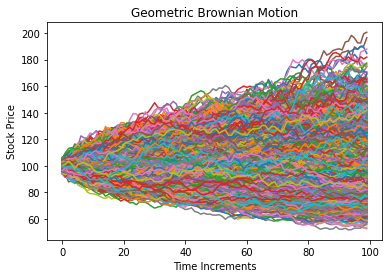

In [ ]:
S = 100 #stock price S_{0}
K = 110 # strike
T = 1/2 # time to maturity
r = 0.05 # risk free risk in annual %
q = 0.02 # annual dividend rate
sigma = 0.25 # annual volatility in %
steps = 100 # time steps
N = 10000 # number of trials

paths= BrownianMotion(S,T,r,q,sigma,steps,N)

plt.plot(paths);
plt.xlabel("Time Increments")
plt.ylabel("Stock Price")
plt.title("Geometric Brownian Motion")

A multidimensional geometric Brownian motion can be specified through a system of SDEs, assuming you want to simulate a portfolio of d stocks. The information relating to the correlations between the stocks is contained within the Brownian motions. This leads to a simple algorithm for simulating multidimensional GBM.

In [1]:
def MultivariateGBM(seed, So, q, sigma, Cov, T, Steps):
    """
    Inputs
    seed:   seed of simulation
    So:     initial stocks' price
    q:      expected return
    sigma:  volatility
    Cov:    covariance matrix
    T:      time period
    Steps:  number of increments
    
    Outputs
    S:      stock price
    dt:     corresponding time
    """

    np.random.seed(seed)
    dim = np.size(So)
    dt = np.linspace(0., T, int(Steps))
    A = np.linalg.cholesky(Cov)
    S = np.zeros([dim, int(Steps)])
    S[:, 0] = So
    for i in range(1, int(Steps)):    
        drift = (q - 0.5 * sigma**2) * (t[i] - t[i-1])
        Z = np.random.normal(0., 1., dim)
        diffusion = np.matmul(A, Z) * (np.sqrt(t[i] - t[i-1]))
        S[:, i] = S[:, i-1]*np.exp(drift + diffusion)
    return S, dt

In [ ]:
!pip install yfinance

In [3]:
from yfinance import Ticker
def get_ohlc(ticker, period='60d', interval='5m'):
  cols = ['Close']
  ohlc = Ticker(ticker).history(period=period, interval=interval)[cols][:-1]
  return ohlc

In [4]:
df1 = get_ohlc('ETH-USD')
df2 = get_ohlc('BTC-USD')

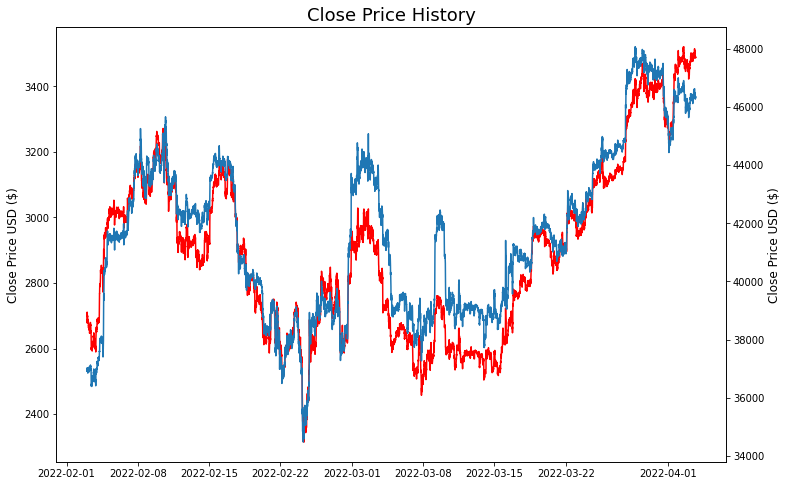

In [12]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12,8))
plt.title('Close Price History', fontsize = 18)
ax.plot(df1['Close'], color="red")
ax2 = ax.twinx()
ax2.plot(df2['Close'])
plt.xlabel('Date', fontsize = 18)
ax.set_ylabel('Close Price USD ($)', fontsize = 12)
ax2.set_ylabel('Close Price USD ($)', fontsize = 12)
plt.show()

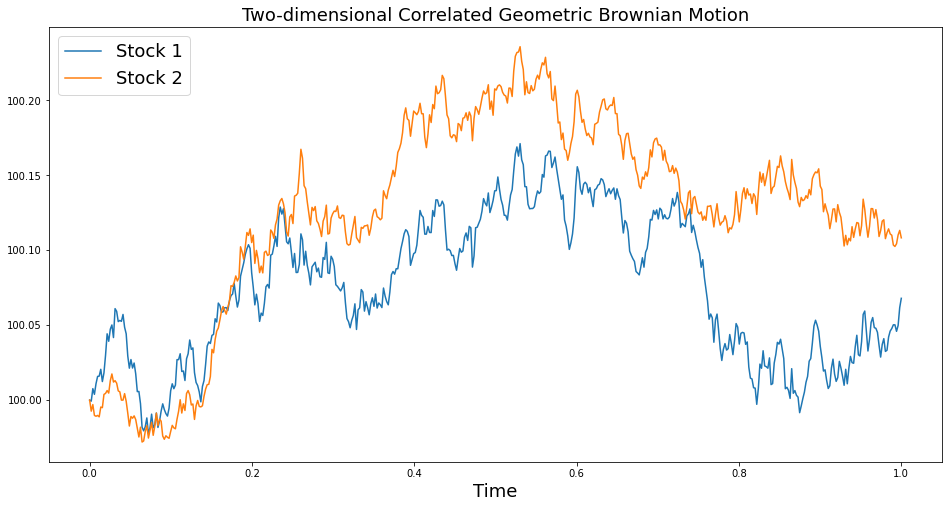

In [15]:
seed = 22                       
dim = 2; T = 1; N = int(2.**9)
S0 = np.array([100, 100])

# Parameter Estimation

# logarithmic returns

df1['log_returns'] = np.log(df1['Close']).diff()
df2['log_returns'] = np.log(df2['Close']).diff()

# expected returns

mean_df1 = df1['log_returns'][1:].mean()
mean_df2 = df2['log_returns'][1:].mean()
mu = [mean_df1, mean_df2]

# volatility
std_df1 = df1['log_returns'][1:].std()
std_df2 = df2['log_returns'][1:].std()
sigma = np.array([std_df1, std_df2])

# covariance matrix
Cov = np.cov(df1['log_returns'][1:], df2['log_returns'][1:] )

stocks, time = MultivariateGBM(seed, S0, mu, sigma, Cov, T, N)

# Visualize Simulation
import matplotlib.pyplot as plt

plt.figure(figsize = (16,8))
plt.title('Two-dimensional Correlated Geometric Brownian Motion', fontsize = 18)
plt.plot(time, stocks[0,:], label='Stock 1')
plt.plot(time, stocks[1,:], label='Stock 2')

plt.xlabel('Time', fontsize = 18)
plt.legend(['Stock 1', 'Stock 2'], loc = 'upper left', fontsize = 18)
plt.show()

In order to apply the Cholesky decomposition it is necessary that the covariance matrix is symmetric ​​positive definite - Scipy library to obtain a random correlation matrix, given a vector of eigenvalues.

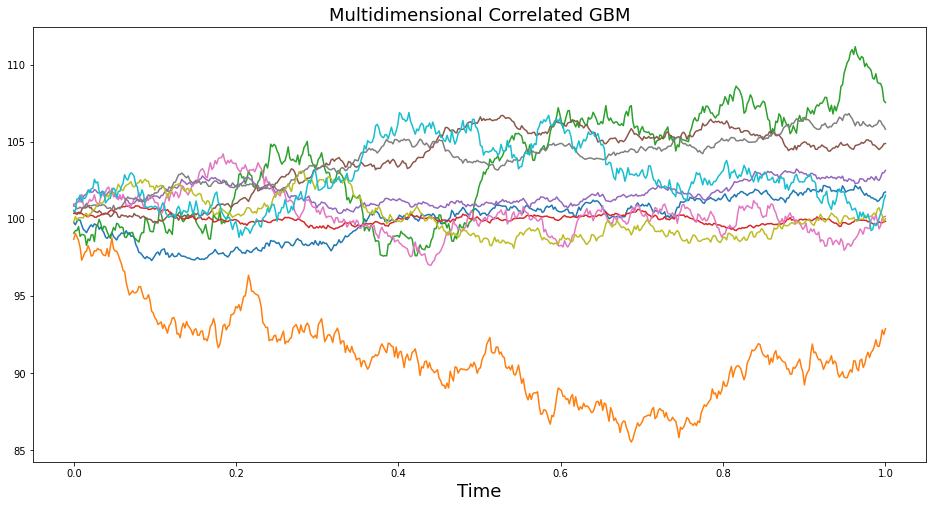

In [16]:
from scipy.stats import random_correlation

seed = 2222                       
dim = 10
T = 1
N = int(2.**9)
S0 = np.random.normal(100, 1, dim)
mu = np.random.uniform(0.01, 0.01, dim)
sigma = np.random.uniform(0.01, 0.1, dim)

if dim == 1:
    corr = np.array([1])
else:
    eig = np.random.uniform(0.1, 1, dim)
    eig = eig/np.sum(eig)*dim                        # Sum of eigenvalues must equal dimensionality.
    corr = random_correlation.rvs(eig)

Cov = np.tensordot(sigma, sigma, 0) * corr           # covariance matrix

stocks, time = MultivariateGBM(seed, S0, mu, sigma, Cov, T, N)
# Number of Simulations

np.random.seed(seed)
simul = int(10)                                       

SS = np.zeros([simul, dim, N])

SS[0, :, :] = stocks

for k in range(1, simul):
    seed = int(np.random.uniform(1,2**32-1,1))
    SS[k, :, :] = MultivariateGBM(seed, S0, mu, sigma, Cov, T, N)[0]

plt.figure(figsize = (16,8))
plt.title('Multidimensional Correlated GBM', fontsize = 18)
plt.xlabel('Time', fontsize = 18)

for j in range(dim):
    plt.plot(time, SS[0, j, :])
plt.show()

# Options Pricing with Monte Carlo Simulation

With the simulations of the underlying price, we consider the payoff in each simulation, where for a long put option at expiry, the payoff is max(P-K, 0) where K is the strike price. These are discounted back to present value and an average is taken of all of the simulations to arrive at an estimate of the option price.

In [ ]:
payoffs = np.maximum(paths[-1]-K, 0)
option_price = np.mean(payoffs)*np.exp(-r*T)

In [ ]:
option_price

3.847482560249035

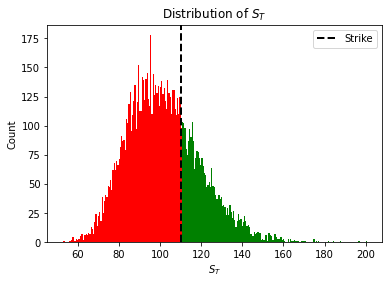

In [ ]:
n, bins, patches = plt.hist(paths[-1],bins=250);
for c, p in zip(bins, patches):
    if c > K:
        plt.setp(p, 'facecolor', 'green')
    else:
        plt.setp(p, 'facecolor', 'red')

plt.axvline(K, color='black', linestyle='dashed', linewidth=2,label="Strike")
plt.title("Distribution of $S_{T}$")
plt.xlabel("$S_{T}$")
plt.ylabel('Count')
plt.legend()

In [ ]:
max_=np.max(paths,axis=0)
payoffs = np.maximum(max_-K, 0)
lookback_price = np.mean(payoffs)*np.exp(-r*T)
print(f"lookback price is {lookback_price}")

lookback price is 7.061502844715245
